In [130]:
import numpy as np
import functools
import math
from matplotlib import collections as mc
import xml.etree.ElementTree as ET
from collections import namedtuple
import csv
import pprint


In [131]:
# Load the XML file
tree = ET.parse('./data_422.xml')
root = tree.getroot()

# Extract information
dataset = root.find('./info/dataset').text
name = root.find('./info/name').text

Vertex = namedtuple("Vertex", ["id", "isWarehouse", "x", "y"])
Request = namedtuple("Request", ["id", "node_id", "quantity"])

In [132]:
car_type = None
for vehicle_profile in root.findall('./fleet/vehicle_profile'):
    departure_node = vehicle_profile.find('departure_node').text
    arrival_node = vehicle_profile.find('arrival_node').text
    capacity = vehicle_profile.find('capacity').text
    car_type = { 'departure_node': departure_node, 'arrival_node': arrival_node, 'capacity': capacity }


In [133]:

nodes = []
warehouse = None
for node in root.findall('./network/nodes/node'):
    node_id = node.attrib['id']
    node_type = node.attrib['type']
    cx = node.find('cx').text
    cy = node.find('cy').text

    if node_type == '0':
        warehouse = Vertex(node_id, True,  float(cx), float(cy))

    nodes.append((node_id, node_type, cx, cy))

assert warehouse is not None

vertices = {}
for node in nodes:
    if node[1] == '0':
        result = True
    else:
        result = False
    vertexid = int(node[0])
    vertices[vertexid] = (Vertex(vertexid, result,  float(node[2]), float(node[3])))


requests_list = []

for request in root.findall('./requests/request'):
    request_id = request.attrib['id']
    node = request.attrib['node']
    quantity = request.find('quantity').text
    requests_list.append({'Request ID': request_id, 'Node': node, 'Quantity': quantity})

requests_list

requests = {}
for request in requests_list:
    requests[request['Request ID']] = (Request(int(request['Request ID']), int(request['Node']), float(request['Quantity'])))

In [134]:
# Define the dictionaries
dictionaries = [requests, vertices]

# Print the first 5 elements of each dictionary
for dictionary in dictionaries:
    print("\n")
    print(*list(dictionary.items())[:5], sep="\n")




('1', Request(id=1, node_id=2, quantity=40.0))
('2', Request(id=2, node_id=3, quantity=40.0))
('3', Request(id=3, node_id=4, quantity=40.0))
('4', Request(id=4, node_id=5, quantity=40.0))
('5', Request(id=5, node_id=6, quantity=40.0))


(421, Vertex(id=421, isWarehouse=True, x=0.0, y=0.0))
(1, Vertex(id=1, isWarehouse=False, x=5.7735, y=0.0))
(2, Vertex(id=2, isWarehouse=False, x=2.8867, y=5.0))
(3, Vertex(id=3, isWarehouse=False, x=-2.8868, y=5.0))
(4, Vertex(id=4, isWarehouse=False, x=-5.7735, y=0.0))


In [135]:
@functools.lru_cache(maxsize=None)
def distance_function(v1, v2):
    return math.sqrt(((v1.x - v2.x) * (v1.x - v2.x)) + ((v1.y - v2.y) * (v1.y - v2.y)))


def fitness_function(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:] + solution[0:1]):
        solution_distance += distance(x, y)
    
    return solution_distance

def initialize_pheromone(N):
    return 0.01 * np.ones(shape=(N,N))


def update_pheromone(pheromones_array, solutions, fitness_values, Q, rho):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fitness_value in zip(solutions, fitness_values):
        for x, y in zip(solution, solution[1:] + solution[0:1]):
            pheromone_update[x.id, y.id] += Q / fitness_value
    
    return (1 - rho) * pheromones_array + pheromone_update

def generate_solutions(vertices, requests, pheromones, distance_function, number_of_ants, car_capacity, alpha=1, beta=3):
    
    # Probability of selecting v2 right after v1
    def compute_prob(v1, req):
        v2 = vertices[int(req)]
        distance = distance_function(v1, v2)
        
        # obezlicka, uvidime jestli to pofacha
        if(distance == 0):
            return 1e-6
        inverse_distance = 1 / distance 
        tau = pheromones[v1.id, v2.id]
        ret = pow(tau, alpha) * pow(inverse_distance, beta)
        return ret if ret > 1e-6 else 1e-6
    
    for _ in range(number_of_ants):
        remaining_requests = list(requests)
        solution = [vertices[1]]  # Start from the warehouse
        capacity = car_capacity
        #print(capacity)
        while remaining_requests:
            probs = np.array([compute_prob(solution[-1], req) for req in remaining_requests])
            probs /= probs.sum()  # Normalize probabilities
            
            selected_index = np.random.choice(len(remaining_requests), p=probs)
            selected_request = remaining_requests[selected_index]
            request = requests[selected_request]
            new_request_capacity = request.quantity

            selected_vertex = vertices[int(selected_request)]

            # Check if adding the selected request exceeds the capacity
            if capacity - new_request_capacity < 0:
                # Revisit the warehouse if capacity is exhausted
                solution.append(vertices[1])
                capacity = car_capacity
                # print("Going back to the warehouse")
            
            else:
                solution.append(selected_vertex)
                remaining_requests.remove(selected_request)
                capacity -= request.quantity  # Decrement capacity
            # print(capacity)
        # Return to the warehouse after serving all requests
        solution.append(vertices[1])
        
        yield solution


def ant_solver(vertices, distance_function, number_of_ants=10, max_iterations=100, alpha=2, beta=3, Q=800, rho=0.90):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float("inf")
    log_of_best_distances = list()
    
    print("Iteration\tMinimum value\tMean value\tMaximum value")
    
    for i in range(max_iterations):
        candidate_solutions = list(generate_solutions(vertices, requests, pheromones, distance_function, number_of_ants, float(car_type['capacity']), alpha=alpha, beta=beta))
        fitness_values = list(map(lambda x: fitness_function(vertices, distance_function, x), candidate_solutions))
        pheromones = update_pheromone(pheromones, candidate_solutions, fitness_values, Q=Q, rho=rho)
        
        for candidate_solution, fitness_value in zip(candidate_solutions, fitness_values):
            if fitness_value < best_fitness:
                best_fitness = fitness_value
                best_solution = candidate_solution
                
        log_of_best_distances.append(np.min(fitness_values))
        
        print(f"{i:8}:\t{np.min(fitness_values):5.8f}\t{np.mean(fitness_values):5.8f}\t{np.max(fitness_values):5.8f}")
    return best_solution, pheromones, log_of_best_distances
print("Request count: ", len(requests))
print("Vertex count: ", len(vertices))
best_solution, pheromones, log_of_best_distances = ant_solver(vertices, distance_function)


Request count:  419
Vertex count:  421
Iteration	Minimum value	Mean value	Maximum value
       0:	7955.00060990	8476.91052891	9045.98325333
       1:	6752.65416807	7137.21396757	7403.02424666
       2:	6342.38902104	6586.39266119	6773.45003788
       3:	5912.35357533	6175.80263809	6429.08582475
       4:	5604.14246298	5923.43556699	6370.57674717
       5:	5268.00819858	5588.43813625	5874.56833480
       6:	5078.61995426	5322.62925205	5549.12443140
       7:	4706.71641373	5082.17063021	5472.79347875
       8:	4437.65858378	4887.63275357	5324.33673209
       9:	4627.86806402	4816.18230606	5036.37189352
      10:	4425.20684274	4731.69584035	4969.87995607
      11:	4327.62441017	4551.37976716	4832.99832786
      12:	4237.34042681	4454.98489232	4804.24571014
      13:	4109.14870284	4365.05773942	4574.58719248
      14:	4044.30012838	4330.83441082	4655.85734563
      15:	4056.17630469	4268.64538497	4532.34493225
      16:	4042.50282938	4248.93422824	4554.59131373
      17:	3705.61622511	4015

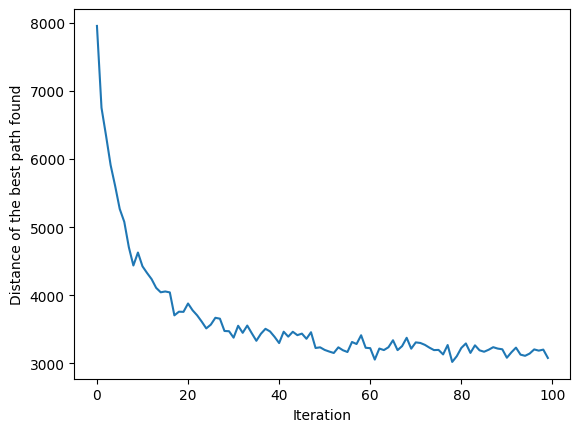

In [136]:
from matplotlib import pyplot as plt

plt.plot(log_of_best_distances)
plt.ylabel("Distance of the best path found")
plt.xlabel("Iteration")
plt.show()

Fitness:  3021.8359206054047


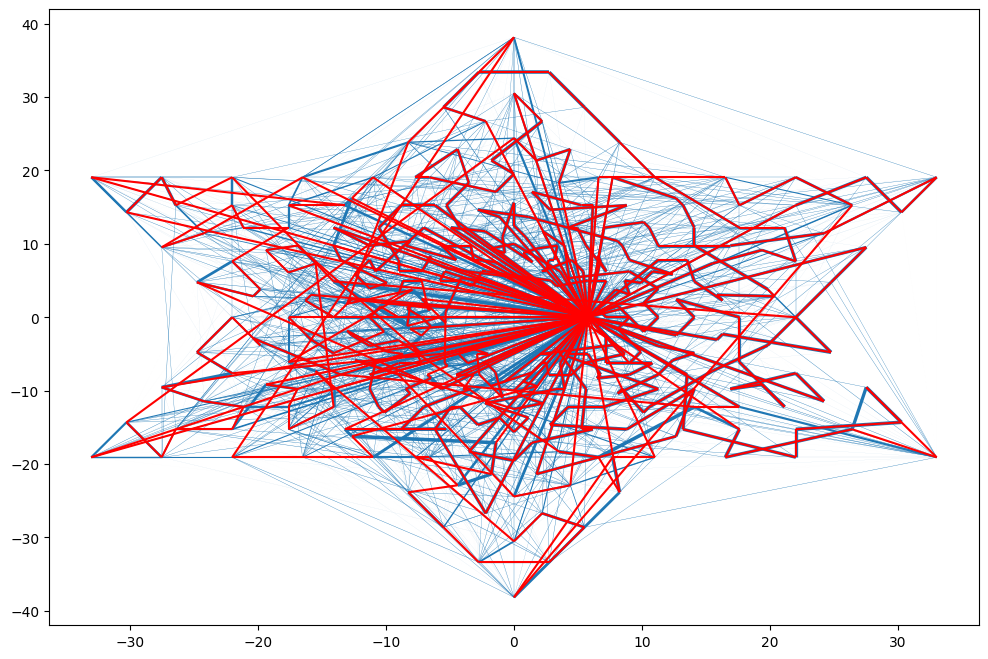

[Vertex(id=1, isWarehouse=False, x=5.7735, y=0.0),
 Vertex(id=13, isWarehouse=False, x=5.3405, y=0.75),
 Vertex(id=1, isWarehouse=False, x=5.7735, y=0.0),
 Vertex(id=54, isWarehouse=False, x=5.3405, y=-0.75),
 Vertex(id=16, isWarehouse=False, x=7.2169, y=-2.5),
 Vertex(id=60, isWarehouse=False, x=7.2169, y=-5.0),
 Vertex(id=119, isWarehouse=False, x=7.2169, y=-6.25),
 Vertex(id=72, isWarehouse=False, x=10.8253, y=-6.25),
 Vertex(id=179, isWarehouse=False, x=9.0211, y=-7.8125),
 Vertex(id=233, isWarehouse=False, x=6.4839, y=-8.3008),
 Vertex(id=178, isWarehouse=False, x=6.7658, y=-7.8125),
 Vertex(id=59, isWarehouse=False, x=5.7735, y=-5.0),
 Vertex(id=58, isWarehouse=False, x=4.3301, y=-5.0),
 Vertex(id=1, isWarehouse=False, x=5.7735, y=0.0),
 Vertex(id=19, isWarehouse=False, x=7.2169, y=2.5),
 Vertex(id=20, isWarehouse=False, x=7.9386, y=3.75),
 Vertex(id=79, isWarehouse=False, x=9.0211, y=3.125),
 Vertex(id=7, isWarehouse=False, x=8.6603, y=5.0),
 Vertex(id=80, isWarehouse=False, x=9

In [137]:
# Render pheromones (blue, line width corresponds to the pheromon value on the edge)
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(vertices[v1].x, vertices[v1].y), (vertices[v2].x, vertices[v2].y)])
        colors.append(pheromones[i, j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# Here, you can test the influence of the individual parameters on the generated candidate solution
# solution = list(generate_solutions(vertices, pheromones, distance_function, number_of_ants=1, alpha=3, beta=1))[0]

# Print solution's fitness
print("Fitness: ", fitness_function(vertices, distance_function, solution))

# Render the solution (red)
solution_lines = []
for i, j in zip(solution, solution[1:] + solution[0:1]):
    solution_lines.append([(i.x, i.y), (j.x, j.y)])

solutions_lc = mc.LineCollection(solution_lines, colors="red")

ax.add_collection(solutions_lc)

plt.show()

# Print towns in the order of the soultion
solution_vertices = [i for i in solution]
pprint.pprint(solution_vertices)